🔧 Using device: cuda


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
▶️  Running LR-Finder …


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
📈  Suggested max_lr (lr_peak) ≈ 3.13e-02
▶️  Training with One-Cycle …
Epoch 01/20 | train_loss=1.7811 | val_loss=1.5613 | val_acc=42.61% | lr=3.26e-03
Epoch 02/20 | train_loss=1.4974 | val_loss=1.4084 | val_acc=49.73% | lr=8.76e-03
Epoch 03/20 | train_loss=1.2936 | val_loss=1.2421 | val_acc=58.29% | lr=1.63e-02
Epoch 04/20 | train_loss=1.1244 | val_loss=1.0588 | val_acc=63.06% | lr=2.38e-02
Epoch 05/20 | train_loss=1.0049 | val_loss=0.9930 | val_acc=65.57% | lr=2.93e-02
Epoch 06/20 | train_loss=0.9248 | val_loss=0.9796 | val_acc=66.32% | lr=3.13e-02
Epoch 07/20 | train_loss=0.8556 | val_loss=0.8469 | val_acc=70.71% | lr=3.09e-02
Epoch 08/20 | train_loss=0.7990 | val_loss=0.8146 | val_acc=72.12% | lr=2.97e-02
Epoch 09/20 | train_loss=0.7554 | val_loss=0.7906 | val_acc=73.29% | lr=2.78e-02
Epoch 10/20 | train_loss=0.7157 | val_loss=0.7070 | val_acc=75.73% | lr=2.54e-02
Epoch 11/2

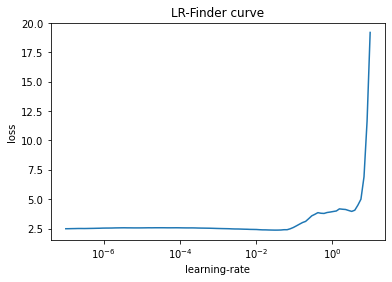

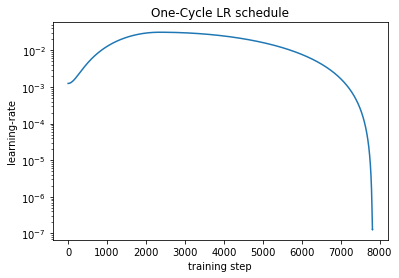

In [1]:
# %% [markdown]
# LR-Finder ➜ One-Cycle on CIFAR-10 (all-in-one Jupyter cell)
# ----------------------------------------------------------
# - Requires PyTorch ≥ 1.13 and Torchvision
# - Auto-installs torch-lr-finder if missing
# - Works on CPU or GPU (CUDA if available)
# ----------------------------------------------------------

# %% Install/Imports
import subprocess, sys, math, os, torch, torch.nn as nn, torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

try:
    from torch_lr_finder import LRFinder          # optional package
except ImportError:
    print("⏳ Installing torch-lr-finder …")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "torch-lr-finder"])
    from torch_lr_finder import LRFinder

# %% Hyper-parameters (tweak here)
EPOCHS              = 20
BATCH_SIZE          = 128
LR_FINDER_START_LR  = 1e-7
LR_FINDER_END_LR    = 10
LR_FINDER_ITERS     = 100          # mini-batches
DIV_FACTOR          = 25.0         # base_lr  = max_lr / DIV_FACTOR
FINAL_DIV_FACTOR    = 1e4          # final_lr = base_lr / FINAL_DIV_FACTOR
PCT_START           = 0.3          # % of steps for upward LR ramp
DEVICE              = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"🔧 Using device: {DEVICE}")

# %% Data
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), transforms.Normalize(mean, std),
])
val_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

train_ds = datasets.CIFAR10("./data", train=True, transform=train_tfms, download=True)
val_ds   = datasets.CIFAR10("./data", train=False, transform=val_tfms , download=True)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# %% Model, criterion
model = models.resnet18(num_classes=10).to(DEVICE)
criterion = nn.CrossEntropyLoss()

# %% ---- 1️⃣  LR-Finder -------------------------------------------------------
base_opt = optim.SGD(model.parameters(), lr=LR_FINDER_START_LR, momentum=0.9, weight_decay=5e-4)
lr_finder = LRFinder(model, base_opt, criterion, device=DEVICE)

print("▶️  Running LR-Finder …")
lr_finder.range_test(train_loader,
                     end_lr=LR_FINDER_END_LR,
                     num_iter=min(LR_FINDER_ITERS, len(train_loader)),
                     step_mode="exp")
# Plot LR-Finder curve
fig, ax = plt.subplots()
ax.plot(lr_finder.history["lr"], lr_finder.history["loss"])
ax.set_xscale("log"); ax.set_xlabel("learning-rate"); ax.set_ylabel("loss"); ax.set_title("LR-Finder curve")

# Heuristic choice: LR just before the loss minimum
losses = torch.tensor(lr_finder.history["loss"])
lrs    = torch.tensor(lr_finder.history["lr"])
best_i = int(torch.argmin(losses))
lr_peak = float(lrs[best_i])
print(f"📈  Suggested max_lr (lr_peak) ≈ {lr_peak:.2e}")

lr_finder.reset()      # restores initial weights

# %% ---- 2️⃣  One-Cycle training ---------------------------------------------
base_lr = lr_peak / DIV_FACTOR
optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=5e-4)
scheduler = OneCycleLR(optimizer,
                       max_lr=lr_peak,
                       epochs=EPOCHS,
                       steps_per_epoch=len(train_loader),
                       pct_start=PCT_START,
                       anneal_strategy="cos",
                       div_factor=DIV_FACTOR,
                       final_div_factor=FINAL_DIV_FACTOR)

def evaluate(net):
    net.eval(); loss_sum = correct = total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = net(xb)
            loss_sum += criterion(out, yb).item() * xb.size(0)
            correct  += out.argmax(1).eq(yb).sum().item()
            total    += xb.size(0)
    return loss_sum / total, correct / total

best_acc = 0
lr_history = []

print("▶️  Training with One-Cycle …")
for epoch in range(1, EPOCHS + 1):
    model.train(); running_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item() * xb.size(0)
        lr_history.append(scheduler.get_last_lr()[0])

    train_loss = running_loss / len(train_loader.dataset)
    val_loss, val_acc = evaluate(model)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={train_loss:.4f} | "
          f"val_loss={val_loss:.4f} | val_acc={val_acc*100:.2f}% | "
          f"lr={scheduler.get_last_lr()[0]:.2e}")

print(f"\n✅  Done!  Best val_acc = {best_acc*100:.2f} %  (model saved to best_model.pt)")

# Plot One-Cycle LR schedule
plt.figure(); plt.plot(lr_history)
plt.yscale("log"); plt.xlabel("training step"); plt.ylabel("learning-rate"); plt.title("One-Cycle LR schedule")
plt.show()
